## Setup and Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm
from sentence_transformers import SentenceTransformer

## Loading Data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Normalizing and Reshapeing Images

In [4]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

In [5]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

In [6]:
print(x_train.shape, x_test.shape)
print(x_train_flat.shape, x_test_flat.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)


## Neural Network Parameters

In [7]:
batch_size = 100
n_epoch = 50
n_hidden= 256
z_dim = 2

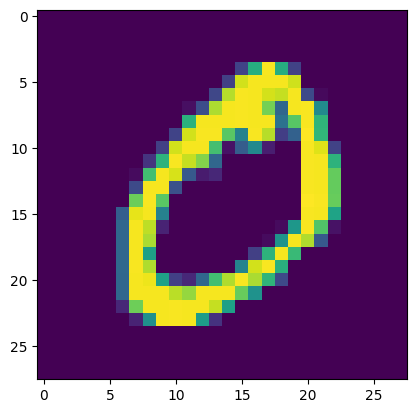

In [8]:
plt.imshow(x_train[1]);

## Create Sampling Function

In [9]:
def sampling(args):
    mu, log_var = args
    epsilon = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(0.5 * log_var) * epsilon

## Create Encoder and Decoder

In [12]:
# Encoder

inputs_flat = Input(shape=(784,))
x = Dense(n_hidden, activation='relu')(inputs_flat)
x = Dense(n_hidden // 2, activation='relu')(x)
mu_flat = Dense(z_dim)(x)
log_var_flat = Dense(z_dim)(x)
z_flat = Lambda(sampling)([mu_flat, log_var_flat])
encoder = Model(inputs_flat, [mu_flat, log_var_flat, z_flat], name="encoder")

In [13]:
# Decoder

latent_inputs = Input(shape=(z_dim,))
x = Dense(n_hidden // 2, activation='relu')(latent_inputs)
x = Dense(n_hidden, activation='relu')(x)
outputs_flat = Dense(784, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs_flat, name="decoder")

## Modeling

In [14]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data

        with tf.GradientTape() as tape:
            mu, log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.keras.backend.sum(
                tf.keras.losses.binary_crossentropy(x, reconstruction), axis=-1
            )
            kl_loss = -0.5 * tf.reduce_sum(
                1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1
            )
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(total_loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data

        mu, log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)

        reconstruction_loss = tf.keras.backend.sum(
            tf.keras.losses.binary_crossentropy(x, reconstruction), axis=-1
        )
        kl_loss = -0.5 * tf.reduce_sum(
            1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1
        )
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

        self.loss_tracker.update_state(total_loss)
        return {"loss": self.loss_tracker.result()}

    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        return self.decoder(z)

In [15]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [16]:
vae.fit(
    x_train_flat,
    epochs=n_epoch,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test_flat, None),
    verbose=1
)

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 31.5144 - val_loss: 24.6831
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 24.6526 - val_loss: 24.1379
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 24.0561 - val_loss: 23.8437
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.7733 - val_loss: 23.6734
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.5789 - val_loss: 23.5091
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.4495 - val_loss: 23.3105
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.3138 - val_loss: 23.2201
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.1609 - val_loss: 23.0869
Epoch 9/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.1474 - val_loss: 23.0585
Epoch 10/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.0473 - val_loss: 23.0171
Epoch 11/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.9922 - val_loss: 22.9779
Epoch 12/50
600/600 ━━━━━━━━━━

## Visualize Embeddings

In [17]:
# Build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat encoder

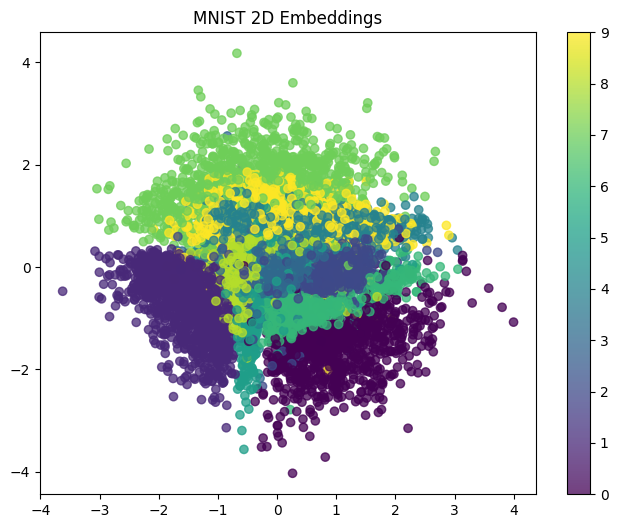

In [18]:
# Plot of the digit classes in the latent space
x_test_latent = encoder_f.predict(x_test_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_test_latent[:, 0], x_test_latent[:, 1], c=y_test, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

## Example: compare three embeddings

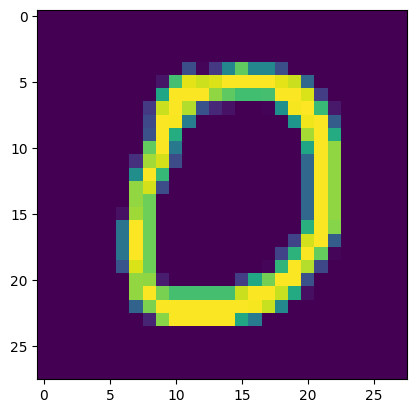

In [19]:
plt.imshow(x_test_flat[10].reshape(28,28));

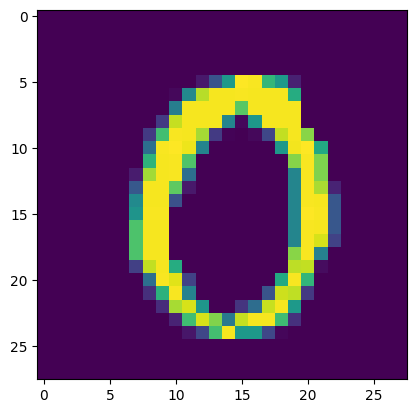

In [20]:
plt.imshow(x_test_flat[13].reshape(28,28));

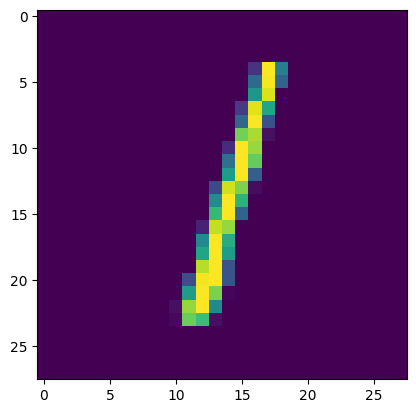

In [21]:
plt.imshow(x_test_flat[2].reshape(28,28));

In [22]:
# calculate vectors for each digit
zero_A = x_test_latent[10]
zero_B = x_test_latent[13]
one = x_test_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

Embedding for the first ZERO is  [ 1.7474113 -1.7004491]
Embedding for the second ZERO is [ 1.0496217 -1.2301903]
Embedding for the ONE is         [-1.8088733 -1.1770959]


## Text Embeddings

In [23]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [24]:
sentence = [
    'The team enjoyed the hike through the meadow',
    'The national park had great views',
    'Olive oil drizzled over pizza tastes delicious'
]

In [25]:
embedding = model.encode(sentence)
print(embedding)
print(embedding.shape)

[[ 0.37061948  0.2641428   0.21265726 ...  0.14994545 -0.25794905
  -0.23970771]
 [ 0.66933304  0.4009497  -0.4820835  ...  0.1064588  -1.5067164
  -0.01547344]
 [-0.26555926  0.11172345 -0.14733039 ...  0.4219751   0.8839462
   0.10763922]]
(3, 384)


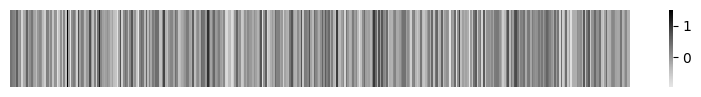

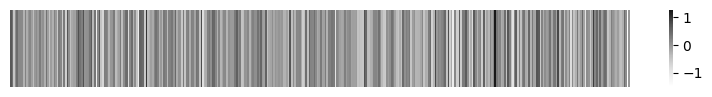

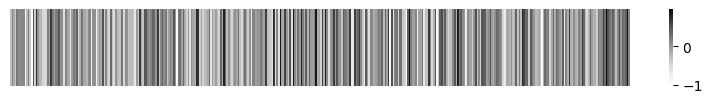

In [26]:
sns.heatmap(embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

## Distance Measuring

There are many ways to calculate the distances between two vectors.

- Euclidean Distance(L2)
- Manhattan Distance(L1)
- Dot Product
- Cosine Distance

### Euclidean Distance(L2)
The length of the shortest path between two points or vectors.

![Euclidean Distance](images/Euclidean_Distance.png)

In [30]:
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)

0.8414592


In [31]:
np.linalg.norm((zero_A - zero_B), ord=2)

np.float32(0.8414592)

In [32]:
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=2))

Distance zeroA-zeroB: 0.8414592
Distance zeroA-one:   3.594587
Distance zeroB-one:   2.858988


### Manhattan Distance(L1)

Distance between two points if one was constrained to move only along one axis at a time.

![Manhattan Distance](images/Manhattan_Distance.png)

In [33]:
L1 = [zero_A[i] - zero_B[i] for i in range(len(zero_A))]
L1 = np.abs(L1).sum()

print(L1)

1.1680484


In [34]:
np.linalg.norm((zero_A - zero_B), ord=1)

np.float32(1.1680484)

In [35]:
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=1))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=1))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=1))

Distance zeroA-zeroB: 1.1680484
Distance zeroA-one:   4.0796375
Distance zeroB-one:   2.9115894


### Dot Product

Measures the magnitude of the projection of one vector onto the other.

![Dot Product](images/Dot_Product.png)

In [36]:
np.dot(zero_A,zero_B)

np.float32(3.9259968)

In [37]:
print("Distance zeroA-zeroB:", np.dot(zero_A, zero_B))
print("Distance zeroA-one:  ", np.dot(zero_A, one))
print("Distance zeroB-one:  ", np.dot(zero_B, one))

Distance zeroA-zeroB: 3.9259968
Distance zeroA-one:   -1.1592538
Distance zeroB-one:   -0.45058072


### Cosine Distance

Measure the difference in directionality between vectors.

![Cosine Distance](images/Cosine_Distance.png)

In [38]:
cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))
print(f"{cosine:.6f}")

0.004290


In [39]:
zero_A/zero_B

array([1.664801 , 1.3822651], dtype=float32)

In [40]:
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

In [41]:
print(f"Distance zeroA-zeroB: {cosine_distance(zero_A, zero_B): .6f}")
print(f"Distance zeroA-one:   {cosine_distance(zero_A, one): .6f}")
print(f"Distance zeroB-one:   {cosine_distance(zero_B, one): .6f}")

Distance zeroA-zeroB:  0.004290
Distance zeroA-one:    1.220305
Distance zeroB-one:    1.129107


## Now with the sentence embeddings!
Dot Product and Cosine Distance are commonly used in the field of NLP, to evaluate how similar two sentence embeddings are. So here we will only use those two.

- embedding0 - 'The team enjoyed the hike through the meadow'
- embedding1 - The national park had great views'
- embedding2 - 'Olive oil drizzled over pizza tastes delicious'

In [42]:
#Dot Product

print("Distance 0-1:", np.dot(embedding[0], embedding[1]))
print("Distance 0-2:", np.dot(embedding[0], embedding[2]))
print("Distance 1-2:", np.dot(embedding[1], embedding[2]))

Distance 0-1: 26.497887
Distance 0-2: 2.0785775
Distance 1-2: 4.0192127


In [43]:
#Cosine Distance

print("Distance 0-1: ", cosine_distance(embedding[0], embedding[1]))
print("Distance 0-2: ", cosine_distance(embedding[0], embedding[2]))
print("Distance 1-2: ", cosine_distance(embedding[1], embedding[2]))

Distance 0-1:  0.5350337
Distance 0-2:  0.9639393
Distance 1-2:  0.9288791
